In [1]:
import wisps
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import Normalize
import astropy.units as u 
import wisps.simulations.effective_numbers as eff
import seaborn as sns
import matplotlib
import popsims
import itertools
#plt.style.use('dark_background')


%matplotlib inline

Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database


In [2]:
 wispsim.MAG_LIMITS

{'wisps': {'F110': (poly1d([ 1.20489888, 18.31086895]), 0.5038943667884174),
  'F140': (poly1d([ 1.49122797, 17.14118556]), 0.7495636144809823),
  'F160': (poly1d([ 1.36561328, 17.37352631]), 1.4165037712823727)},
 'hst3d': {'F110': (None, nan),
  'F140': (poly1d([-0.10025015, 22.66882951]), 0.21335391346949473),
  'F160': (poly1d([ 0.14320198, 21.86199263]), 0.22142403753971857)},
 'ncutoff': 50,
 'snr_exp': {'F110': array([-0.21776363,  0.17478516,  5.58990024]),
  'F140': array([-0.23887768,  0.09906914,  6.05791412]),
  'F160': array([-0.23620309,  0.17130063,  5.92682832])},
 'mag_unc_exp': {'F110': [19.632175805849474,
   -0.34825934107482936,
   0.2541179554241336,
   -2.5316445863281594],
  'F140': [19.883179094204745,
   -0.4297747738627907,
   0.2597682343566299,
   -2.1808887926774023],
  'F160': [18.59282531952516,
   -0.34825934107482936,
   0.2513140745044105,
   -2.469405380320458]},
 'F110': (poly1d([ 1.20489888, 18.31086895]), 0.5038943667884174),
 'F140': (poly1d([ 2.

In [3]:
import popsims
import splat

In [4]:
sgrid=wispsim.SPGRID
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
corr_pols=wisps.POLYNOMIAL_RELATIONS['mag_limit_corrections'] 
klf=pd.read_csv('/users/caganze/research/wisps/data/kirkpatricklf.txt', delimiter=',')
klf['bin_center']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)
klf=klf.replace(0.0,np.nan)

ucds=pd.read_pickle(wisps.LIBRARIES+'/new_real_ucds.pkl')
#cands=cands[(cands.spt >=17) & (cands.snr1>=3)].reset_index(drop=True)
cands=(ucds[ucds.selection!='']).reset_index(drop=True)
tab=wisps.Annotator.reformat_table(cands)
pnt_names=[x.name for x in pnts]

In [5]:
#spgrid

In [6]:
#cmap= sns.color_palette("coolwarm", 8, as_cmap=True)
cmap=matplotlib.cm.get_cmap('coolwarm')
cnorm=Normalize(wispsim.HS[0], (wispsim.HS[-1]))

In [7]:
kirkpatrick2020LF={'bin_center':np.flip(np.array([2025, 1875, 1725, 1575, 1425, 1275, 1125 , 975, 825, 675, 525])), 
                   'values':np.flip(np.array([0.72, 0.50,0.78, 0.81,0.94, 1.95, 1.11, 1.72, 1.99, 2.80, 4.24])), 
                   'unc':np.flip(([0.18, 0.17, 0.20,0.20, 0.22, 0.3, 0.25, 0.3, 0.32, 0.37, 0.70]))}


In [8]:
MODEL_NAMES=['burrows1997', 'burrows2001', 'baraffe2003', 'saumon2008', 'marley2019', 'phillips2020']
MODEL_SHORT_NAMES=['B97', 'B01', 'B03', 'SM08', 'M19', 'P20']


In [9]:
def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[17, 20], [20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def get_all_numbers():
    #Distribute the parameter sets evenly across the cores
    func=lambda x, y:  get_simulated_number_model(y, x)

    paramlist=[(i, j)  for i, j in itertools.product(MODEL_NAMES, wispsim.HS)]
    res  = [func(x, y) for x,y in tqdm(paramlist)]
    
    nbrs = {}
    for k in MODEL_NAMES:
        ds0={}
        for j in res:
            if k in j.keys():
                key=[x for x in j[k].keys()][0]
                ds0.update({key: [(j[k][key])[yi] for yi in wispsim.SPGRID]})
        #print (ds0)
        nbrs[k]=np.array([ds0[k] for k in wispsim.HS])

    return nbrs
    


def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]


def iswithin_mag_limits(mags, pnt, spt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] <= pnt.mag_limits[k]+ (corr_pols[k+'W'][0])(spt))
    return np.logical_or.reduce(flags)

def get_simulated_number_model(hidx, model):
    #hidx is a scale height, model is evolutionary model
    df=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut_binaries.h5',\
                       key=str(model)+str(hidx)+str('spt_abs_mag'))
    cutdf=(df[~df.is_cut]).rename(columns={'temperature': 'teff', \
                                          'slprob': 'sl'})
    #cutdf=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(hidx)+'F110_corrected')
    #scl_dict=pd.read_pickle(wisps.OUTPUT_FILES+'/lf_scales.pkl') 
    #scales=scl_dict[model]
    scale=[cutdf.scale.mean(), cutdf.scale_unc.mean(), cutdf.scale_times_model.mean()]
    #scale=scale_lf_teff(cutdf.teff)
    NSIM=dict(zip(wispsim.SPGRID,np.zeros((len(wispsim.SPGRID), 2))))
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        sn= len(cutdf.teff[np.logical_and(cutdf.teff>=450, cutdf.teff<=2100)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        #scln=np.array(scale)
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].sl)*scln
    del cutdf
    return {model: {hidx:NSIM}}



In [10]:
MODEL_NAMES

['burrows1997',
 'burrows2001',
 'baraffe2003',
 'saumon2008',
 'marley2019',
 'phillips2020']

In [11]:
#cutdf.scale

In [12]:
def plot_one(NUMBERS, VOLUMES, filename='/oberved_numbers_one_panel.pdf'):
    data_to_save={}
    # In[ ]:
    nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
    
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)-THICK
    yall=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)-THICK
    
    dy2=np.sqrt(y2)
    dyall=np.sqrt(yall)
     #add this to the dictionary
    data_to_save['nall']=nall
    data_to_save['nobs']=nobs
    data_to_save['yall']=yall
    data_to_save['y2']=y2

    fig, a=plt.subplots(figsize=(8, 6))
    
    #for model, a in zip(['baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'], np.concatenate(ax)):
    model='baraffe2003'
    for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            a.plot(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False), 
                          color= cmap(cnorm(h)), 
                   linewidth=3, drawstyle="steps-mid")
            a.fill_between(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns+nuncs, ltonly=False),  
                           bin_by_spt_bin(wispsim.SPGRID,ns-nuncs, ltonly=False), alpha=0.5, 
                           color= cmap(cnorm(h/100)),  step="mid")
        
        
    a.set_yscale('log')
    #a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='#111111')
    #a.errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', mfc='white', fmt='o')
    a.set_xlabel('SpT',fontsize=18)
    a.set_ylabel('N',fontsize=18)
    a.minorticks_on()
            

    #a.set_title('Model= SM08', fontsize=18)
    a.set_title('Model= B03', fontsize=18)
    #a.set_title('Model= M19', fontsize=18)
    #a.set_title('Model= P20', fontsize=18)

    a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', label='Mag Limited')
    #a.errorbar(spgrid2,yall, yerr=dyall, fmt='o', label='All Observations')
    
    cax = fig.add_axes([.5, 0.7, .3, 0.03])
    mp=matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    cbar=plt.colorbar(mp, cax=cax, orientation='horizontal')
    cbar.ax.set_xlabel(r'Scaleheight (H)', fontsize=18)
    #cbar.ax.set_yticks([1, 3, 5, 10])
    #a.legend(fontsize=14, loc='upper left')
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+filename, bbox_inches='tight')
    

In [13]:
#d=pd.read_pickle(wisps.OUTPUT_FILES+'/distance_samples{}'.format(h))

In [14]:
#expectted counts from thick disk
THICK=np.array([8.79798048, 2.30571423, 0.14145726, 0.08853498, 0.01784511])

In [15]:

tab['pnt']=tab['grism_id'].apply(get_pointing)
tab['spt_val']=np.vstack(tab.spt.values)[:,0]
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')

flags=[iswithin_mag_limits(x, y, z) for x, y, z in zip(obsmgs, tab.pnt.values,tab.spt.values )]

#let's see what happens if we include all objects
#flags=np.ones(len(flags)).astype(bool)
cdf_to_use=tab[flags]

nobs=wisps.custom_histogram(cdf_to_use.spt_val.apply(wisps.make_spt_number), sgrid, 1)


spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']
spgrid3=['Late M', 'L', 'T']

In [16]:
sgrid,

(array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),)

In [17]:
#for k in ['F140', 'F110', 'F160']:
#    tab['lim_{}'.format(k)]=tab.pnt.apply(lambda x: x.mag_limits[k])
#    tab['detected_{}'.format(k)]= tab[k+'W'] < tab['lim_{}'.format(k)]

In [18]:
flags=np.array(flags)

In [19]:
spgrid=np.arange(17, 42)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


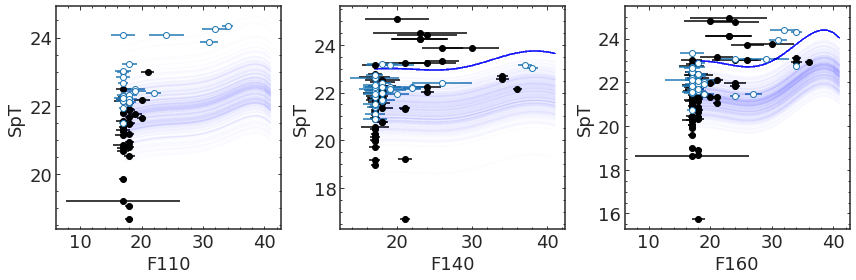

In [20]:
fig, ax=plt.subplots(figsize=(12, 4), ncols=3)

ax[0].errorbar(tab.spt[flags], tab.F110W[flags], xerr=tab.spt_er[flags], yerr=tab.F110W_er[flags], fmt='o', c='k')
ax[0].errorbar(tab.spt[~flags], tab.F110W[~flags], xerr=tab.spt_er[~flags], yerr=tab.F110W_er[~flags], \
                mfc='white', fmt='o')

ax[1].errorbar(tab.spt[flags], tab.F140W[flags], xerr=tab.spt_er[flags], yerr=tab.F140W_er[flags], fmt='o', c='k')
ax[1].errorbar(tab.spt[~flags], tab.F140W[~flags], xerr=tab.spt_er[~flags], yerr=tab.F140W_er[~flags], \
                mfc='white', fmt='o')


ax[-1].errorbar(tab.spt[flags], tab.F160W[flags], xerr=tab.spt_er[flags], yerr=tab.F160W_er[flags], fmt='o', c='k')
ax[-1].errorbar(tab.spt[~flags], tab.F160W[~flags], xerr=tab.spt_er[~flags], yerr=tab.F160W_er[~flags], \
                mfc='white', fmt='o')

for p in pnts:
    ax[0].plot(spgrid, p.mag_limits['F110']+(corr_pols['F110'+'W'][0])(spgrid), alpha=0.01, c='b')
    ax[1].plot(spgrid, p.mag_limits['F140']+(corr_pols['F140'+'W'][0])(spgrid), alpha=0.01, c='b')
    ax[-1].plot(spgrid, p.mag_limits['F160']+(corr_pols['F160'+'W'][0])(spgrid), alpha=0.01, c='b')

ax[0].set_xlabel('F110')
ax[1].set_xlabel('F140')
ax[-1].set_xlabel('F160')
ax[0].set_ylabel('SpT')
ax[1].set_ylabel('SpT')
ax[-1].set_ylabel('SpT')

for a in ax:
    a.minorticks_on()
plt.tight_layout()

In [21]:
#wisps.POLYNOMIALS

In [22]:
#.MAG_LIMITS

In [23]:
subtab=(tab[tab.spt.between(30, 35)]).reset_index(drop=True)

In [24]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print( subtab[['F140W', 'F160W', 'lim_F140', 'lim_F160', 'detected_F140', 'detected_F160', 'grism_id',
#                  'spt']])

In [25]:
#NUMBERS=pd.read_pickle(wisps.OUTPUT_FILES+'/numbers_simulated.pkl')
NUMBERS=get_all_numbers()

100%|██████████| 72/72 [10:11<00:00,  8.49s/it]


In [26]:
NUMBERS.keys()

dict_keys(['burrows1997', 'burrows2001', 'baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'])

In [27]:
#plt.hist(np.log10(NUMBERS['baraffe2003'][0][:,1]))

In [28]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

VOLUMES=(np.nansum(volumes, axis=0))*4.1*(u.arcmin**2).to(u.radian**2)

In [29]:
MODEL_NAMES, MODEL_SHORT_NAMES

(['burrows1997',
  'burrows2001',
  'baraffe2003',
  'saumon2008',
  'marley2019',
  'phillips2020'],
 ['B97', 'B01', 'B03', 'SM08', 'M19', 'P20'])

In [30]:

def plot(NUMBERS, VOLUMES, filename='/oberved_numbers.pdf'):
    # In[ ]:
    nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
    
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)-THICK
    yall=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)
    
    dy2=np.sqrt(y2)
    dyall=np.sqrt(yall)

    fig, ax=plt.subplots(figsize=(14, 8), ncols=3, nrows=2, sharey=True, sharex=False)
    
    for model, name, a in zip(MODEL_NAMES, MODEL_SHORT_NAMES, np.concatenate(ax)):
        
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            a.plot(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False), 
                          color= cmap(cnorm(h)), 
                   linewidth=3, drawstyle="steps-mid")
            #a.fill_between(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns+nuncs, ltonly=False),  
             #              bin_by_spt_bin(wispsim.SPGRID,ns-nuncs, ltonly=False), alpha=0.5, 
             #              color= cmap(cnorm(h/100)),  step="mid")
        
        a.set_yscale('log')
        a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='#111111')
        a.errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', mfc='white', fmt='o')
        a.set_xlabel('SpT',fontsize=18)
        a.set_ylabel('N',fontsize=18)
        a.minorticks_on()
        a.set_title('Model= {}'.format(name), fontsize=18)
            

    ax[1][-2].errorbar(spgrid2,y2, yerr=dy2,fmt='o', label='Mag Limited', color='#111111')
    ax[1][-2].errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', fmt='o', mfc='white', label='All Observations')
    
    #ax[-1][-2].legend(fontsize=14,  bbox_to_anchor=(1.05, 1), loc='upper left')
    #fig.delaxes(np.concatenate(ax)[-1])
    ax[1][-2].legend( fontsize=14, loc='upper right')
    
    cax = fig.add_axes([1.01, 0.25, .015, 0.5])
    mp=matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
    cbar.ax.set_ylabel(r'Scaleheight (H, pc)', fontsize=18)
    #cbar.ax.set_yticks([1, 3, 5, 10])
    #np.concatenate(ax)[-2].legend(loc='center left', bbox_to_anchor=(1, 1.5), fontsize=14)
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+filename, bbox_inches='tight')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


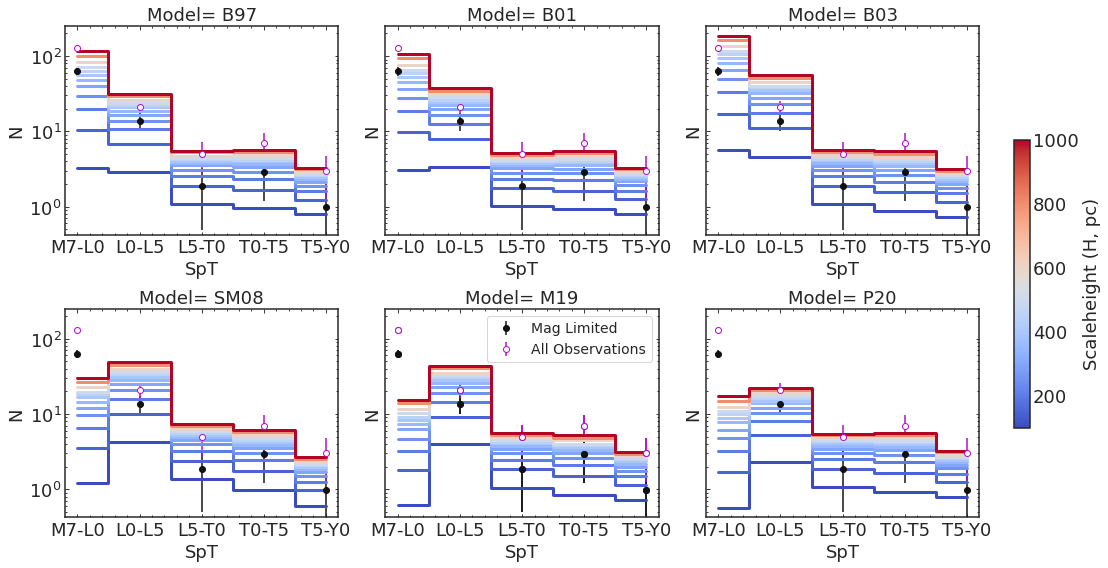

In [31]:
 plot(NUMBERS, VOLUMES, filename='/obs_numbers_plus_binaries.pdf')

In [32]:
#save into pickle file
#NUMBERS
counts_numbers={'volumes': VOLUMES, 'densities': NUMBERS, 'scaleheights': wispsim.HS, 'nobs': nobs}
import pickle
with open(wisps.OUTPUT_FILES+'/expected_numbers_wisps_plus_binaries.pkl', 'wb') as file:
    pickle.dump(counts_numbers,file)

In [33]:
nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)-THICK

In [34]:
def asymetric_errors(vals):
    if len(vals)<1:
        return [np.nan, np.nan]
    else:
        med= np.nanmedian(vals)
        up= np.nanpercentile(vals, 86)
        dn= np.nanpercentile(vals, 14)
        return np.array([med-dn, up-med])

In [35]:
np.nanpercentile(wispsim.HS, 10)

155.00000000000003

In [36]:
#just for L dwarfs and T dwarfs
y3=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)-THICK
y4=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=True)#-THICK
y5= np.nansum(y4)
print ('all ----- {}'.format(y3))
print ('used ----- {}'.format(y2))
print ('MLT ----{}'.format(y4))
print ('All ----{}'.format(y5))


all ----- [120.20201952  18.69428577   4.85854274   6.91146502   2.98215489]
used ----- [63.20201952 13.69428577  1.85854274  2.91146502  0.98215489]
MLT ----[72, 18, 4]
All ----94


In [37]:
#PRINT THE BEST FIT NUMBER 
#best_fit={}
numbers_fit={} #predictions for all
numbers_fit_lt={} #predictions for M, L, T
#numbers_fit_total={} #predictions for total number counts
for model in MODEL_NAMES:
        model_number_lt={}
        model_number={}
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            binned=np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False))
            binned_lt= np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=True))
            #binned_unc=np.array(bin_by_spt_bin(wispsim.SPGRID,nuncs, ltonly=False))
            #add L and 
            #compute chi-squared
            #print (ns)
            #chisq= abs((y2-binned)**2/(y2))
            #model_fit.update({h: chisq})
            #binned_total=np.append(binned, binned_lt)
            #binned_total=np.append(binned, binned_lt)
            model_number.update({h: binned})
            model_number_lt.update({h: binned_lt})
        # best_fit.update({model: model_fit})
        numbers_fit.update({model: model_number})
        numbers_fit_lt.update({model:  model_number_lt})

In [38]:
#chisq_dicts=pd.DataFrame.from_records(best_fit)
pred_number_dicts=pd.DataFrame.from_records(numbers_fit)
pred_number_lt_dicts=pd.DataFrame.from_records(numbers_fit_lt)

In [39]:
from scipy.interpolate import interp1d

In [40]:
import scipy.stats as stats

In [41]:


def get_poisson_predictions(spt_grid, obstns, predns):
    res={}
    for c in  predns.columns:
        min_vals={}
        dist={}
        #for idx,s  in enumerate(np.append(spgrid2, ['L dwarfs', 'T dwarfs'])):
        for idx,s  in enumerate(spt_grid):
            #compare between subtypes
            #predicted
            predvals=(np.vstack(predns[c].values))[:,idx]
            #observed
            nreal=  obstns[idx]
            #make an interpolation function
            interpf = interp1d(predvals, wispsim.HS)
            #using a 2nd degree polynomial 
            #interpf = np.poly1d(np.polyfit(predvals, wispsim.HS, 3))

            #draw a bunch of random values based on a poisson distribution
            #npoisson=np.random.poisson(nreal, 100000).astype(float)
            #print (nreal)
            npoisson=stats.gamma.rvs(nreal, size =int(1e5))
            #stay within the range of possible values to avoid interpolation error
            #i.e take this as a prior
            #dflag=npoisson>=vals.min()
            #uflag= npoisson <=vals.max()
            #npoisson[dflag]= vals.min()
            #npoisson[uflag]= vals.max()
            #allow extraploayion
            npoisson=npoisson[np.logical_and(npoisson>=predvals.min(), npoisson <=predvals.max())]
            #predict scale heights
            predhs=interpf(npoisson)
            #use a weighted mean and std 
            #mean, unc= (np.nanmean(predhs), np.nanstd(predhs))

            #print (' scale height for model {} and spt {} is {} +/- {} '.format(c, s, np.round(mean), np.round(unc, 4)))
            dist.update({s:predhs})
        #min_chi_ssqrs.update({c:min_vals})
        res.update({c: dist})
    return  res

In [1]:
popsims.avr_yu?

Object `popsims.avr_yu` not found.


In [42]:
def scaleheight_to_vertical_disp(hs):
    shape=435 #shape parameter
    sigma_68=1.
    return np.sqrt((np.array(hs))/shape)*20

def compute_age_with_z(sigmas, z):
    ag_bov= popsims.avr_yu(sigmas[abs(z) >270], verbose=True, nsample=2, height='above')[0]
    ag_bel=popsims.avr_yu(sigmas[abs(z) <=270], verbose=True, nsample=2, height='below')[0]
    return np.concatenate([ag_bov, ag_bel]).flatten()

def asssymetric_med_std(x):
    return np.round(np.nanmedian(x), 2), np.round(asymetric_errors(x), 2)

In [43]:
def avr_aumer(sigma,  direction='vertical', verbose=False):
    #return the age from an age-velocity dispersion 
    verboseprint = print if verbose else lambda *a, **k: None
    result=None
    beta_dict={'radial': [0.307, 0.001, 41.899],
                'total': [ 0.385, 0.261, 57.15747],
                'azimuthal':[0.430, 0.715, 28.823],
                'vertical':[0.445, 0.001, 23.831],
                }

    verboseprint("Assuming Aumer & Binney 2009 Metal-Rich Fits and {} velocity ".format(direction))

    beta, tau1, sigma10=beta_dict[direction]
       
    result=((sigma/sigma10)**(1/beta))*(10+tau1)-tau1

    return result

In [45]:
scale_height_dist=get_poisson_predictions(spgrid2, y2,pred_number_dicts)
scale_height_dist_df=pd.DataFrame(scale_height_dist)

In [ ]:
#scale_height_dist

In [ ]:
scale_height_dist_df['saumon2008']['M7-L0']=[]

In [46]:
#scale_height_dist=get_poisson_predictions(spgrid2, y2,pred_number_dicts)
#scale_height_dist_df=pd.DataFrame(scale_height_dist)
vel_df=scale_height_dist_df.applymap(scaleheight_to_vertical_disp)
age_distdf_yu=vel_df.applymap(lambda x: popsims.avr_yu(x, verbose=False, nsample=2, height='median')[0])
age_distdf_just=vel_df.applymap(lambda x: popsims.avr_just(x, verbose=False))
age_distdf_sand=vel_df.applymap(lambda x: popsims.avr_sanders(x, verbose=False))
age_distdf_aumer=vel_df.applymap(lambda x: avr_aumer(x, verbose=False))



scalh_tables=scale_height_dist_df.applymap( asssymetric_med_std)
vel_tables=vel_df.applymap(asssymetric_med_std)
age_tables_yu=age_distdf_yu.applymap( asssymetric_med_std)
age_tables_just=age_distdf_just.applymap( asssymetric_med_std)
age_tables_sand=age_distdf_sand.applymap( asssymetric_med_std)
age_tables_aumer=age_distdf_aumer.applymap( asssymetric_med_std)

In [47]:
import matplotlib as mpl
mpl.rcParams['figure.titlesize'] = 'large'

In [48]:
pred_number_dicts.keys()

Index(['baraffe2003', 'burrows1997', 'burrows2001', 'marley2019',
       'phillips2020', 'saumon2008'],
      dtype='object')

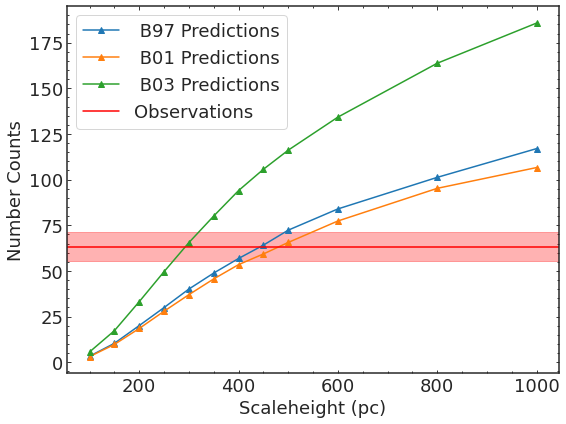

In [49]:
idx=0
fig, ax=plt.subplots(figsize=(8, 6))
for m, ac in zip(['burrows1997', 'burrows2001', 'baraffe2003',], ['B97', 'B01', 'B03']):
    predvals=(np.vstack(np.vstack(pred_number_dicts[m].values)))[:,idx]
    #observed

    #make an interpolation function
    #interpf = np.poly1d(np.polyfit(predvals, wispsim.HS, 3))
    interpf =interp1d(predvals, wispsim.HS)

    rvs=stats.gamma.rvs(y2[idx], size =int(1e5))
    #rvs=rvs[np.logical_and(rvs>=predvals.min(), rvs <=predvals.max())]

    ax.plot(  wispsim.HS, predvals, marker='^', label=' {} Predictions'.format(ac))
    #ax[0].plot(  rvs, interpf(rvs), '.')
    
ax.axhline(y2[idx], color='r', label='Observations')
ax.axhspan(y2[idx]-np.sqrt(y2[idx]), y2[idx]+np.sqrt(y2[idx]), alpha=0.3, color='red')

ax.set(xlabel='Scaleheight (pc)', ylabel='Number Counts')


ax.minorticks_on()
ax.legend()
#fig.delaxes(ax0[1])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/model_interpolation_ncounts.pdf', bbox_inches='tight')

In [50]:
def reformat(val):
    return str(val[0])+'$ _{-'+str(val[1][0])+'} ^{+'+str(val[1][1])+'}$'

In [51]:
scalh_tables[MODEL_NAMES].applymap(reformat)

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020
M7-L0,441.15$ _{-54.76} ^{+55.76}$,478.32$ _{-67.77} ^{+75.01}$,291.81$ _{-25.71} ^{+30.0}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$
L0-L5,241.41$ _{-53.11} ^{+82.44}$,210.46$ _{-40.62} ^{+58.33}$,167.73$ _{-27.48} ^{+32.73}$,178.88$ _{-30.17} ^{+39.45}$,188.46$ _{-33.27} ^{+46.87}$,333.38$ _{-92.53} ^{+171.28}$
L5-T0,165.03$ _{-50.19} ^{+138.91}$,172.11$ _{-55.67} ^{+160.33}$,166.63$ _{-51.44} ^{+144.92}$,148.45$ _{-36.98} ^{+99.93}$,168.08$ _{-52.54} ^{+146.23}$,166.07$ _{-51.11} ^{+145.96}$
T0-T5,225.32$ _{-90.31} ^{+225.46}$,229.58$ _{-92.94} ^{+237.21}$,237.97$ _{-98.51} ^{+236.85}$,219.48$ _{-86.04} ^{+202.92}$,242.26$ _{-101.18} ^{+261.05}$,225.98$ _{-89.99} ^{+226.6}$
T5-Y0,172.31$ _{-57.12} ^{+177.59}$,169.07$ _{-54.32} ^{+180.6}$,174.91$ _{-59.39} ^{+190.25}$,184.88$ _{-66.88} ^{+219.28}$,176.03$ _{-59.81} ^{+184.52}$,169.77$ _{-55.25} ^{+182.3}$


In [52]:
vel_tables[MODEL_NAMES].applymap(reformat)

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020
M7-L0,20.14$ _{-1.29} ^{+1.23}$,20.97$ _{-1.54} ^{+1.58}$,16.38$ _{-0.74} ^{+0.82}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$
L0-L5,14.9$ _{-1.74} ^{+2.36}$,13.91$ _{-1.41} ^{+1.81}$,12.42$ _{-1.06} ^{+1.16}$,12.83$ _{-1.13} ^{+1.34}$,13.16$ _{-1.22} ^{+1.55}$,17.51$ _{-2.63} ^{+4.03}$
L5-T0,12.32$ _{-2.04} ^{+4.4}$,12.58$ _{-2.23} ^{+4.9}$,12.38$ _{-2.09} ^{+4.55}$,11.68$ _{-1.56} ^{+3.43}$,12.43$ _{-2.12} ^{+4.57}$,12.36$ _{-2.08} ^{+4.58}$
T0-T5,14.39$ _{-3.25} ^{+5.97}$,14.53$ _{-3.32} ^{+6.19}$,14.79$ _{-3.47} ^{+6.1}$,14.21$ _{-3.13} ^{+5.5}$,14.93$ _{-3.54} ^{+6.59}$,14.42$ _{-3.23} ^{+5.98}$
T5-Y0,12.59$ _{-2.3} ^{+5.35}$,12.47$ _{-2.2} ^{+5.46}$,12.68$ _{-2.38} ^{+5.64}$,13.04$ _{-2.62} ^{+6.24}$,12.72$ _{-2.38} ^{+5.49}$,12.49$ _{-2.23} ^{+5.5}$


In [53]:
age_tables_just[MODEL_NAMES].applymap(reformat)

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020
M7-L0,6.67$ _{-1.11} ^{+1.18}$,7.45$ _{-1.4} ^{+1.63}$,3.77$ _{-0.46} ^{+0.55}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$
L0-L5,2.89$ _{-0.86} ^{+1.47}$,2.38$ _{-0.63} ^{+0.98}$,1.71$ _{-0.4} ^{+0.51}$,1.88$ _{-0.45} ^{+0.62}$,2.03$ _{-0.5} ^{+0.76}$,4.54$ _{-1.66} ^{+3.47}$
L5-T0,1.67$ _{-0.71} ^{+2.32}$,1.78$ _{-0.79} ^{+2.74}$,1.7$ _{-0.73} ^{+2.43}$,1.43$ _{-0.51} ^{+1.58}$,1.72$ _{-0.74} ^{+2.46}$,1.69$ _{-0.72} ^{+2.45}$
T0-T5,2.62$ _{-1.38} ^{+4.25}$,2.69$ _{-1.43} ^{+4.51}$,2.83$ _{-1.53} ^{+4.54}$,2.53$ _{-1.31} ^{+3.76}$,2.91$ _{-1.58} ^{+5.08}$,2.63$ _{-1.38} ^{+4.27}$
T5-Y0,1.78$ _{-0.81} ^{+3.07}$,1.73$ _{-0.77} ^{+3.11}$,1.82$ _{-0.85} ^{+3.32}$,1.97$ _{-0.97} ^{+3.94}$,1.84$ _{-0.85} ^{+3.22}$,1.74$ _{-0.78} ^{+3.15}$


In [54]:
#upper and lo limits on ages 
#up_lims_table=pd.DataFrame(columns= age_tables.columns,
#                           index=age_tables.index).fillna(0)
#up_lims_table.saumon2008['T0-T5']=1
#up_lims_table.saumon2008['T0-T5']=1

#lo limts
#lo_lims_table=pd.DataFrame(columns= age_tables.columns,
#                           index=age_tables.index).fillna(0)
#lo_lims_table.baraffe2003['T5-Y0']=1
#lo_lims_table.baraffe2003['L5-T0']=1
#lo_lims_table.phillips2020['T5-Y0']=1
#lo_lims_table.saumon2008['T5-Y0']=1
#lo_lims_table.marley2019['T5-Y0']=1


In [55]:
def get_simpler_class(x):
    if x.startswith('M'):
        return 'Late M'
    if x.startswith('L'):
        return 'L'
    if x.startswith('T'):
        return 'T'

In [56]:
def get_age_dictionaries(model):
    dfs=[]
    for hidx in wispsim.HS:
        #hidx is a scale height, model is evolutionary model
        df0=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut_binaries.h5',\
                          key=str(model)+str(hidx)+str('spt_abs_mag'))
        cutdf=(df0[~df0.is_cut]).rename(columns={'temperature': 'teff', \
                                              'slprob': 'sl'})
        
        
        dfs.append(cutdf)
        
    df=pd.concat(dfs)
    print (len(df))
    cutdf_lblded=wisps.Annotator.group_by_spt(df, spt_label='spt', assign_number=False).rename(columns={'spt_range': 'subtype'})
    cutdf_lblded['spectclass']=  cutdf_lblded.subtype.apply(get_simpler_class)
    final_df=cutdf_lblded[~((cutdf_lblded.spectclass=='') | (cutdf_lblded.subtype=='')|   (cutdf_lblded.subtype=='trash'))]

    return final_df[['age', 'subtype', 'spt', 'spectclass']]

In [57]:
#plot age with scale heights
age_dictionaries={}
for model in tqdm(MODEL_NAMES):
       age_dictionaries[model]= get_age_dictionaries(model)
    

  0%|          | 0/6 [00:00<?, ?it/s]

2316179


 17%|█▋        | 1/6 [01:42<08:32, 102.56s/it]

2392161


 33%|███▎      | 2/6 [03:07<06:29, 97.37s/it] 

2947054


 50%|█████     | 3/6 [04:55<05:01, 100.37s/it]

2425810


 67%|██████▋   | 4/6 [06:33<03:19, 99.78s/it] 

2178677


 83%|████████▎ | 5/6 [07:56<01:34, 94.69s/it]

1970905


100%|██████████| 6/6 [09:26<00:00, 94.43s/it]


In [58]:
#a.errorbar(  agfn.age, agfn.subtype, xerr=np.vstack(agfn.unc).T,  fmt='o',xlolims=lolims, ms=20, lw=7, 
#               capsize=7, 
#               mfc='#0074D9', mec='#111111', ecolor='#111111', xuplims=uplims)
#age_dictionaries[model].columns

In [59]:
#plot_one(NUMBERS, VOLUMES, filename='/oberved_numbers_one_panel.pdf')

In [60]:
def plot_one_age(a):
    model='baraffe2003'
    ds=[]
    dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
    for k in age_tables_just[model].keys():
        if len(scale_height_dist[model][k]) <1:
            pass
        else:
            #empirical
            #ds0.append(age_tables_just[model][k])
            #from simulations
            ds.append(dfn.age[dfn.subtype==k].values)
    #some reformatting
    positions=[0, 1, 2, 3, 4]
    lolims=[0, 0, 0, 0, 0]
    if len(ds) ==4: positions=[1, 2, 3, 4]
    v1 = a.violinplot(ds,points=100, positions=positions,
               showmeans=True, showextrema=False, showmedians=False, vert =False)
    #for b in v1['bodies']: 
    #      b.set_color('#0074D9')
        #get the center
    xerr0=np.vstack((age_tables_just[model].apply(lambda x: x[1]).values)).T
    xerr1=np.vstack((age_tables_sand[model].apply(lambda x: x[1]).values)).T
    xerr2=np.vstack((age_tables_aumer[model].apply(lambda x: x[1]).values)).T
    
    #set size of arrows
    xerr0.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    xerr1.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    xerr2.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    
    #a.errorbar(age_tables_just[model].apply(lambda x: x[0]).values, [0, 1, 2, 3, 4],\
    #           xerr=xerr0,  fmt='o', label='J10', \
    #          ms=10, lw=5,  capsize=5,
    #           xlolims=lolims)
    
    #a.errorbar(age_tables_yu[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.2,\
    #           xerr=np.vstack((age_tables_yu[model].apply(lambda x: x[1]).values)).T,  fmt='o', label='Y18',
    #           ms=10, lw=5,  mfc='#B10DC9', mec='#B10DC9', ecolor='#B10DC9', capsize=5)
    
    #a.errorbar(age_tables_sand[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.0,\
    #           xerr=xerr1,  fmt='o', label='SB15',
    #           ms=10, lw=5,  mfc='#B10DC9', mec='#B10DC9', ecolor='#B10DC9', capsize=5,
    #            xlolims=lolims)
    
    #a.errorbar(age_tables_aumer[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.01,\
    #           xerr=xerr2,  fmt='o', label='AB09',
    #           ms=10, lw=5, capsize=5,
    #            xlolims=lolims)
    
    a.set_yticks([0, 1, 2, 3, 4])
    a.set_yticklabels(spgrid2)
    a.set_xlabel('Age (Gyr)', fontsize=18)
    a.set_ylabel('Subtype', fontsize=18)
    a.minorticks_on()
    a.set_xlim([-1, 10])
    a.set_title('Model= B03', fontsize=18)
    #a.legend(fontsize=12, loc='lower left')
   
    plt.tight_layout()
    

In [61]:
##plt.style.use('dark_background')
#fig, ax=plt.subplots(figsize=(6, 8))
#plot_one_age(ax)
#plt.savefig(wisps.OUTPUT_FIGURES+'/age_comparison_simsonly.pdf', bbox_inches='tight')

In [62]:
import scipy.stats as stats

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


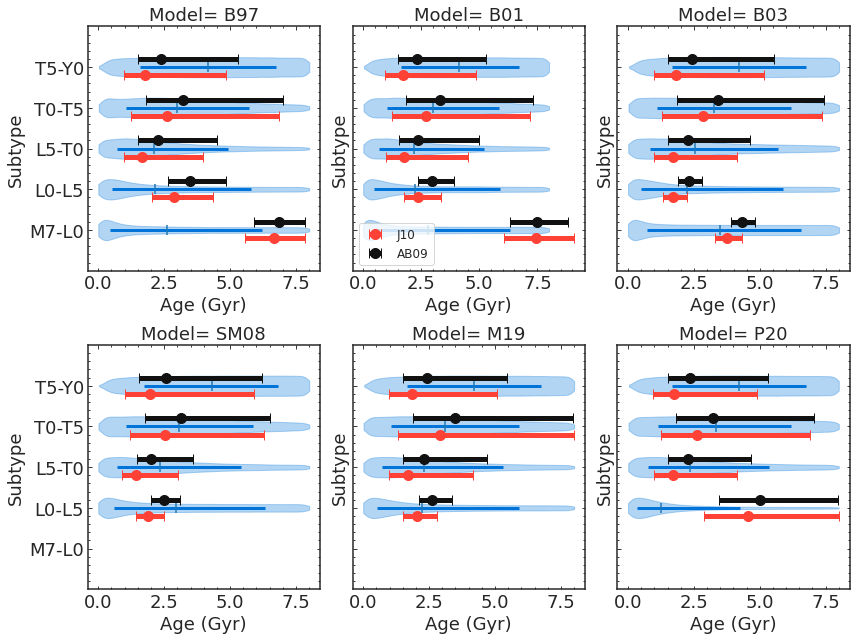

In [63]:
fig, ax=plt.subplots(figsize=(12, 9), ncols=3, nrows=2, sharex=False, sharey=True)
for model, name, a in zip( MODEL_NAMES, MODEL_SHORT_NAMES, np.concatenate(ax)):

    ds=[]
    qs=[]
    
    dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
    for k in age_tables_just[model].keys():
        if len(scale_height_dist[model][k]) <1:
            pass
            qs.append([np.nan, np.nan])
        else:
            #empirical
            #ds0.append(age_tables_just[model][k])
            #from simulations
            ds.append(dfn.age[dfn.subtype==k].values)
            qs.append(np.percentile(dfn.age[dfn.subtype==k].values, [16, 84]))
    #some reformatting
    qs=np.vstack(qs)
    a.hlines([0, 1, 2, 3, 4], qs[:,0], qs[:,1], color='#0074D9', linestyle='-', lw=3)
    positions=[0, 1, 2, 3, 4]
    lolims=[0, 0, 0, 0, 0]
    if len(ds) ==4: positions=[1, 2, 3, 4]
    v1 = a.violinplot(ds,points=100, positions=positions,
               showmeans=False, showextrema=False, showmedians=True, vert =False)
    for b in v1['bodies']: 
          b.set_color('#0074D9')
        #get the center
    xerr0=np.vstack((age_tables_just[model].apply(lambda x: x[1]).values)).T
    xerr1=np.vstack((age_tables_sand[model].apply(lambda x: x[1]).values)).T
    xerr2=np.vstack((age_tables_aumer[model].apply(lambda x: x[1]).values)).T
    
    #set size of arrows
    xerr0.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    xerr1.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    xerr2.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    
    a.errorbar(age_tables_just[model].apply(lambda x: x[0]).values, np.array([0, 1, 2, 3, 4])-0.2,\
               xerr=xerr0,  fmt='o', label='J10', \
              ms=10, lw=5,  mfc='#FF4136', mec='#FF4136', ecolor='#FF4136', capsize=5,
               xlolims=lolims)
    
    #a.errorbar(age_tables_yu[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.2,\
    #           xerr=np.vstack((age_tables_yu[model].apply(lambda x: x[1]).values)).T,  fmt='o', label='Y18',
    #           ms=10, lw=5,  mfc='#B10DC9', mec='#B10DC9', ecolor='#B10DC9', capsize=5)
    
    #a.errorbar(age_tables_sand[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.0,\
    #           xerr=xerr1,  fmt='o', label='SB15',
    #           ms=10, lw=5,  mfc='#B10DC9', mec='#B10DC9', ecolor='#B10DC9', capsize=5,
    #            xlolims=lolims)
    
    a.errorbar(age_tables_aumer[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.2,\
               xerr=xerr2,  fmt='o', label='AB09',
               ms=10, lw=5,  mfc='#111111', mec='#111111', ecolor='#111111', capsize=5,
                xlolims=lolims)
    
    a.set_yticks([0, 1, 2, 3, 4])
    a.set_yticklabels(spgrid2)
    a.set_xlabel('Age (Gyr)', fontsize=18)
    a.set_ylabel('Subtype', fontsize=18)
    a.minorticks_on()
    a.set_ylim([-1, 5])
    a.set_title('Model= {}'.format(name), fontsize=18)
    
ax[0][-2].legend(fontsize=12, loc='lower left')

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/age_comparison_plus_binaries.pdf', bbox_inches='tight',  \
            facecolor='white', transparent=True)

In [64]:
scale_height_dist['saumon2008']['M7-L0']=[]

In [65]:
np.shape(ds)

(4,)

In [66]:
#fig, ax=plt.subplots()
np.percentile((scale_height_dist[model][k]).flatten(), [25,75], axis=0)

array([127.70002728, 257.95171389])

In [67]:
from matplotlib.collections import LineCollection

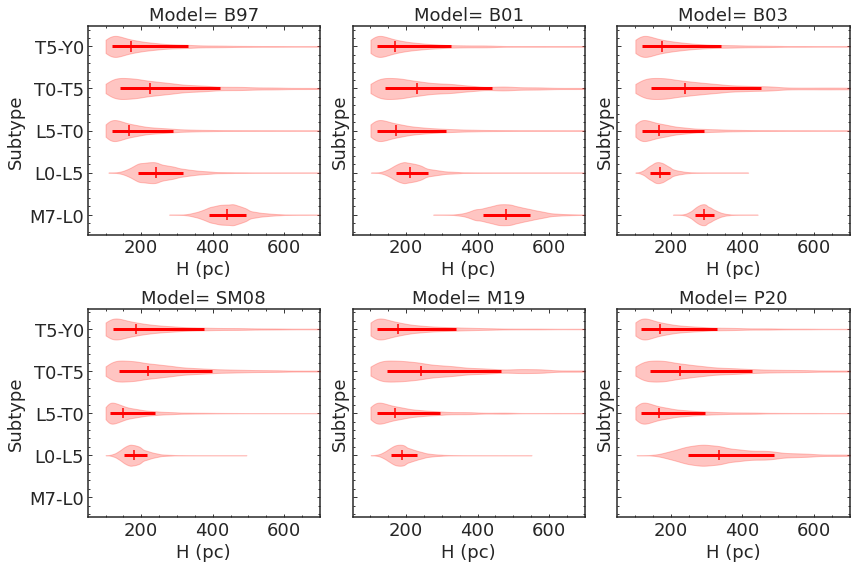

In [68]:
fig, ax=plt.subplots(figsize=(12, 8), ncols=3, nrows=2, sharex=False, sharey=True)

for model, name, a in zip( MODEL_NAMES, MODEL_SHORT_NAMES, np.concatenate(ax)):
    ds=[]
    qs=[]
    for k in scale_height_dist[model].keys():
        if len(scale_height_dist[model][k]) <1:
            pass
            qs.append([np.nan, np.nan])
        else:
            ds.append(scale_height_dist[model][k])
            qs.append(np.percentile(scale_height_dist[model][k], [16, 84]))
            
    qs=np.vstack(qs)
    a.hlines([0, 1, 2, 3, 4], qs[:,0], qs[:,1], color='r', linestyle='-', lw=3)

    positions=[0, 1, 2, 3, 4]
    if len(ds) ==4: positions=[1, 2, 3, 4]
    v1 = a.violinplot(ds,points=3000, positions=positions,
               showmeans=False, showmedians=True,  \
                      showextrema=False, vert =False)
    for b in v1['bodies']: 
          b.set_color('#FF4136')
    v1['cmedians'].set_color('r')
        #get the center
    a.set_yticks([0, 1, 2, 3, 4])
    a.set_yticklabels(spgrid2)
    a.set_xlabel('H (pc)', fontsize=18)
    a.set_ylabel('Subtype', fontsize=18)
    a.minorticks_on()
    a.set(xlim=[50, 700])
    a.set_title('Model= {}'.format(name), fontsize=18)


plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/scaleheight_comparison_plus_binaries.pdf', bbox_inches='tight',  \
            facecolor='white', transparent=True)


In [69]:
a.violinplot?

In [70]:
ls=np.concatenate([np.concatenate(scale_height_dist_df.loc['L0-L5'].values).flatten(),\
                  np.concatenate(scale_height_dist_df.loc['L5-T0'].values).flatten()])

ts=np.concatenate([np.concatenate(scale_height_dist_df.loc['T0-T5'].values).flatten(),\
                  np.concatenate(scale_height_dist_df.loc['T5-Y0'].values).flatten()])

In [71]:
print ('T ', asssymetric_med_std(ts))

T  (210.05, array([ 83.46, 221.85]))


In [72]:
171+134

305

In [73]:
print ('L ', asssymetric_med_std(ls))

L  (192.01, array([ 57.09, 115.08]))


In [74]:
print ('M ',asssymetric_med_std(np.concatenate(scale_height_dist_df.loc['M7-L0'].values).flatten()))

M  (417.99, array([131.13,  91.62]))


In [75]:
#print ('T ',asssymetric_med_std(np.concatenate(scale_height_dist_df.loc['T-L0'].values).flatten()))

In [76]:
ignore_models_dict={'L0-L5': ['phillips2020'], 'M7-L0':[], 'L5-T0':[],\
                    'T0-T5':[], 'T5-Y0':[],  'T5-Y0':[]}

In [77]:
def get_median(df, subtype, rund=1):
    ignore_models=ignore_models_dict[subtype]
    all_models=MODEL_NAMES
    mds=[x for x in all_models if x not in ignore_models]
    vs=np.concatenate(df[mds].loc[subtype].values).flatten()
    val, unc=asssymetric_med_std(vs)
    res=''
    if np.isnan(val):
            res += r'\nodata'
    else:
        if rund <1:
                st=str(int(np.round(val, rund)))+ '$_{-'+ str(int(np.round(unc[0], rund)))+'}'+\
                '^{+'+str(int(np.round(unc[1], rund)))+'} $&'
        else:
                st=str(np.round(val, rund))+ '$_{-'+ str(np.round(unc[0], rund))+'}'+\
                '^{+'+str(np.round(unc[1], rund))+'} $&'
        res += st
    
    return res
def get_formatted_string(df, subtype, rund=1):
    dn=df.loc[subtype]
    res=''
    for md in MODEL_NAMES:
        val= dn[md][0]
        unc=dn[md][1]
        if np.isnan(val):
            res += r'\nodata &'
        else:
            if rund <1:
                st=str(int(np.round(val, rund)))+ '$_{-'+ str(int(np.round(unc[0], rund)))+'}'+\
                '^{+'+str(int(np.round(unc[1], rund)))+'} $&'
            else:
                st=str(np.round(val, rund))+ '$_{-'+ str(np.round(unc[0], rund))+'}'+\
                '^{+'+str(np.round(unc[1], rund))+'} $&'
            res += st
    return res

def get_age_median_from_simulation(subtype, rund=1):
    res=''
    
    for model in MODEL_NAMES:
        dfn0=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
        dfn=dfn0[dfn0.subtype==subtype]
        if len(scale_height_dist[model][subtype]) <1:
            res += r'\nodata &'
        else:
            val, unc= asssymetric_med_std(dfn['age'].values)
            if rund <1:
                st=str(int(np.round(val, rund)))+ '$_{-'+ str(int(np.round(unc[0], rund)))+'}'+\
                '^{+'+str(int(np.round(unc[1], rund)))+'} $&'
            else:
                st=str(np.round(val, rund))+ '$_{-'+ str(np.round(unc[0], rund))+'}'+\
                '^{+'+str(np.round(unc[1], rund))+'} $&'
            res += st
    return res

def get_age_median_all_from_simulation(subtype, rund=1):
    ignore_models=ignore_models_dict[subtype]
    ds=[]
    res=''
    all_models=MODEL_NAMES
    mds=[x for x in all_models if x not in ignore_models]
    for model in mds:
        dfn0=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
        ds.append(dfn0[dfn0.subtype==subtype].age.values)
    val, unc=asssymetric_med_std(np.concatenate(ds))
    st=str(np.round(val, rund))+ '$_{-'+ str(np.round(unc[0], rund))+'}'+\
                '^{+'+str(np.round(unc[1], rund))+'} $&'
    res += st
    return res

def get_ks_stats(subtype, rund=1, compareto='aumer'):
    res=''
    for model in MODEL_NAMES:
        dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
        x=dfn[dfn.subtype ==subtype].age.values
        if compareto=='aumer': y=age_distdf_aumer[model][subtype]
        if compareto=='just': y=age_distdf_just[model][subtype]
        if len(y)<2:
            res +=r'\nodata'
        else:
            val=stats.ks_2samp(x, y, mode='asymp', alternative='two-sided')[0]
            st= str(np.round(val, rund))+'&'
            res += st
    return res

In [78]:
def custom_overlap_probability(subtype, ranges=[0, 13], rund=3, compareto='aumer'):
    grid=np.linspace(ranges[-1], ranges[1], 100)
   
    res=''
    for model in MODEL_NAMES:
        dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
        x=dfn[dfn.subtype ==subtype].age.values
        if compareto=='aumer':y=age_distdf_aumer[model][subtype]
        if compareto=='just': y=age_distdf_just[model][subtype]
        if len(y)<2:
            res +='\nodata'
        else:
            #Create overlapping probabilities
            kde_sim=stats.kde.gaussian_kde(x)
            kde_obs=stats.kde.gaussian_kde(y)

            num=np.trapz(kde_sim(grid)*kde_obs(grid), x=grid)
            den=np.trapz(kde_sim(grid), x=grid)*np.trapz(kde_obs(grid), x=grid)
            val=num/den
            st= str(np.round(val, rund))+'&'
            res += st
    
    return res
                                                
                            

In [79]:
grid=np.linspace(0, 13, 5000 )
x=np.random.normal(5, 1, 1000)
y=np.random.normal(5, 1, 1000)

In [80]:
kde_sim=stats.kde.gaussian_kde(x)
kde_obs=stats.kde.gaussian_kde(y)

num=np.trapz(kde_sim(grid)*kde_obs(grid), x=grid)
den=np.trapz(kde_sim(grid), x=grid)*np.trapz(kde_obs(grid), x=grid)

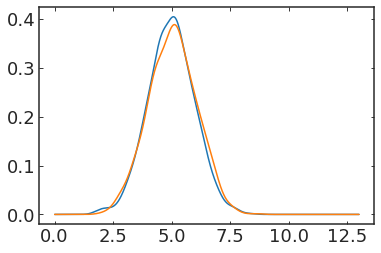

In [81]:
plt.plot(grid, kde_sim(grid))
plt.plot(grid, kde_obs(grid))

In [82]:
num/den

0.2728579214330291

In [83]:
scalh_tables

,baraffe2003,burrows1997,burrows2001,marley2019,phillips2020,saumon2008
M7-L0,"(291.81, [25.71, 30.0])","(441.15, [54.76, 55.76])","(478.32, [67.77, 75.01])","(nan, [nan, nan])","(nan, [nan, nan])","(nan, [nan, nan])"
L0-L5,"(167.73, [27.48, 32.73])","(241.41, [53.11, 82.44])","(210.46, [40.62, 58.33])","(188.46, [33.27, 46.87])","(333.38, [92.53, 171.28])","(178.88, [30.17, 39.45])"
L5-T0,"(166.63, [51.44, 144.92])","(165.03, [50.19, 138.91])","(172.11, [55.67, 160.33])","(168.08, [52.54, 146.23])","(166.07, [51.11, 145.96])","(148.45, [36.98, 99.93])"
T0-T5,"(237.97, [98.51, 236.85])","(225.32, [90.31, 225.46])","(229.58, [92.94, 237.21])","(242.26, [101.18, 261.05])","(225.98, [89.99, 226.6])","(219.48, [86.04, 202.92])"
T5-Y0,"(174.91, [59.39, 190.25])","(172.31, [57.12, 177.59])","(169.07, [54.32, 180.6])","(176.03, [59.81, 184.52])","(169.77, [55.25, 182.3])","(184.88, [66.88, 219.28])"


In [84]:
scalh_tables

,baraffe2003,burrows1997,burrows2001,marley2019,phillips2020,saumon2008
M7-L0,"(291.81, [25.71, 30.0])","(441.15, [54.76, 55.76])","(478.32, [67.77, 75.01])","(nan, [nan, nan])","(nan, [nan, nan])","(nan, [nan, nan])"
L0-L5,"(167.73, [27.48, 32.73])","(241.41, [53.11, 82.44])","(210.46, [40.62, 58.33])","(188.46, [33.27, 46.87])","(333.38, [92.53, 171.28])","(178.88, [30.17, 39.45])"
L5-T0,"(166.63, [51.44, 144.92])","(165.03, [50.19, 138.91])","(172.11, [55.67, 160.33])","(168.08, [52.54, 146.23])","(166.07, [51.11, 145.96])","(148.45, [36.98, 99.93])"
T0-T5,"(237.97, [98.51, 236.85])","(225.32, [90.31, 225.46])","(229.58, [92.94, 237.21])","(242.26, [101.18, 261.05])","(225.98, [89.99, 226.6])","(219.48, [86.04, 202.92])"
T5-Y0,"(174.91, [59.39, 190.25])","(172.31, [57.12, 177.59])","(169.07, [54.32, 180.6])","(176.03, [59.81, 184.52])","(169.77, [55.25, 182.3])","(184.88, [66.88, 219.28])"


In [85]:
#print latex formatted 
for idx, subtype in enumerate(spgrid2):
    print (subtype + r'&$H$ (pc) &' + get_formatted_string(scalh_tables, subtype, rund=0) \
           + get_median(scale_height_dist_df, subtype, rund=0) +  \
           str(int(np.round(y2)[idx]))+'&'+  str(np.round(THICK[idx], 1)) + r'\\ ')
    print (r' & $\sigma_w$ (km/s)  &' + get_formatted_string(vel_tables, subtype) \
           + get_median(vel_df, subtype) + '& '+ r'\\ ')
    print (r' & Age (Gyr) (J10) &' + get_formatted_string(age_tables_just, subtype) \
           + get_median(age_distdf_just, subtype)+ '& ' + r'\\ ')
    #print (r' & Age (Gyr) (SB15)&' + get_formatted_string(age_tables_sand, subtype)  \
    #       + get_median(age_distdf_sand, subtype) + r'\\ ')
    #print (r' & Age (Gyr) (Y18)&' + get_formatted_string(age_tables_yu, subtype)  \
    #       + get_median(age_distdf_yu, subtype) + r'\\ ')
    print (r' & Age (Gyr) (A09)&' + get_formatted_string(age_tables_aumer, subtype)  \
           + get_median(age_distdf_aumer, subtype)+ '& '  + r'\\ ')
    
    print (r' & Age (Gyr) (Simulation)&' + get_age_median_from_simulation(subtype, rund=1)  \
           + get_age_median_all_from_simulation(subtype, rund=1)+ '& ' + r'\\ ')
    
    print (r' & KS (A09-Simulation) & ' + get_ks_stats(subtype, rund=1, compareto='aumer')\
           +  '& ' + r'\\ ')
    
    print (r' & KS (J10-Simulation) & ' + get_ks_stats(subtype, rund=1, compareto='just')\
           +  '& ' + r'\\ ')

M7-L0&$H$ (pc) &441$_{-55}^{+56} $&478$_{-68}^{+75} $&292$_{-26}^{+30} $&\nodata &\nodata &\nodata &418$_{-131}^{+92} $&63&8.8\\ 
 & $\sigma_w$ (km/s)  &20.1$_{-1.3}^{+1.2} $&21.0$_{-1.5}^{+1.6} $&16.4$_{-0.7}^{+0.8} $&\nodata &\nodata &\nodata &19.6$_{-3.4}^{+2.0} $&& \\ 
 & Age (Gyr) (J10) &6.7$_{-1.1}^{+1.2} $&7.4$_{-1.4}^{+1.6} $&3.8$_{-0.5}^{+0.6} $&\nodata &\nodata &\nodata &6.2$_{-2.5}^{+1.9} $&& \\ 
 & Age (Gyr) (A09)&6.8$_{-1.0}^{+1.0} $&7.5$_{-1.2}^{+1.3} $&4.3$_{-0.4}^{+0.5} $&\nodata &\nodata &\nodata &6.4$_{-2.2}^{+1.6} $&& \\ 
 & Age (Gyr) (Simulation)&2.6$_{-2.2}^{+3.8} $&2.8$_{-2.4}^{+3.7} $&3.5$_{-2.9}^{+3.2} $&\nodata &\nodata &\nodata &2.8$_{-2.5}^{+3.7} $&& \\ 
 & KS (A09-Simulation) & 0.7&0.7&0.5&\nodata\nodata\nodata& \\ 
 & KS (J10-Simulation) & 0.7&0.7&0.4&\nodata\nodata\nodata& \\ 
L0-L5&$H$ (pc) &241$_{-53}^{+82} $&210$_{-41}^{+58} $&168$_{-27}^{+33} $&179$_{-30}^{+39} $&188$_{-33}^{+47} $&333$_{-93}^{+171} $&192$_{-38}^{+64} $&14&2.3\\ 
 & $\sigma_w$ (km/s)  

In [86]:
###################run same analysis for combined L and T d

In [87]:
y4, THICK

([72, 18, 4],
 array([8.79798048, 2.30571423, 0.14145726, 0.08853498, 0.01784511]))

In [88]:
ltotal_scaleheight={}
ttotal_scaleheight={}

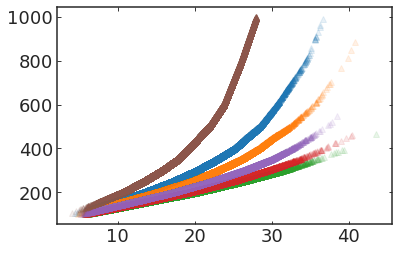

In [89]:
#compute rvs for 
fig, ax=plt.subplots()
for m in MODEL_NAMES:
    predvals=np.vstack(np.vstack(pred_number_dicts[m].values))[:,1]+\
    np.vstack(np.vstack(pred_number_dicts[m].values))[:,2]
    interpf =interp1d(predvals, wispsim.HS)
    rvs=stats.gamma.rvs(17, size =int(1e5))
    npoisson=rvs[np.logical_and(rvs>=predvals.min(), rvs <=predvals.max())]
    ltotal_scaleheight.update({m: interpf(npoisson)})
    ax.plot(npoisson, interpf(npoisson), '^', alpha=0.1)
    
#compute rvs for 
for m in MODEL_NAMES:
    predvals=np.vstack(np.vstack(pred_number_dicts[m].values))[:,3]+\
    np.vstack(np.vstack(pred_number_dicts[m].values))[:,4]
    interpf =interp1d(predvals, wispsim.HS)
    rvs=stats.gamma.rvs(4, size =int(1e5))
    npoisson=rvs[np.logical_and(rvs>=predvals.min(), rvs <=predvals.max())]
    ttotal_scaleheight.update({m: interpf(npoisson)})

In [90]:
ltotal_scaleheight.keys()

dict_keys(['burrows1997', 'burrows2001', 'baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'])

In [91]:
ltotal_scaleheight['combined']=np.concatenate([ltotal_scaleheight[k] \
                                for k in ltotal_scaleheight.keys()])
ttotal_scaleheight['combined']=np.concatenate([ttotal_scaleheight[k] \
                                for k in ttotal_scaleheight.keys()])

In [92]:
ttotal_vdisp={}
ltotal_vdisp={}

ttotal_age_just={}
ttotal_age_aumer={}

ltotal_age_just={}
ltotal_age_aumer={}
for k in ttotal_scaleheight.keys():
    ltotal_vdisp.update({k:scaleheight_to_vertical_disp(ltotal_scaleheight[k])})
    ttotal_vdisp.update({k:scaleheight_to_vertical_disp(ttotal_scaleheight[k])})
    
    ttotal_age_just.update({k: popsims.avr_just(ttotal_vdisp[k], verbose=False)})
    ttotal_age_aumer.update({k: avr_aumer(ttotal_vdisp[k], verbose=False)})
    
    ltotal_age_just.update({k:  popsims.avr_just(ltotal_vdisp[k], verbose=False)})
    ltotal_age_aumer.update({k:avr_aumer(ltotal_vdisp[k], verbose=False)})
    
    

In [93]:
#

In [94]:
lt_df_h=pd.DataFrame(columns= ttotal_scaleheight.keys(), index=['L', 'T'])
lt_df_age_aumer=pd.DataFrame(columns= ttotal_scaleheight.keys(), index=['L', 'T'])
lt_df_age_just=pd.DataFrame(columns= ttotal_scaleheight.keys(), index=['L', 'T'])
lt_df_v=pd.DataFrame(columns= ttotal_scaleheight.keys(), index=['L', 'T'])

In [95]:
for k in ttotal_scaleheight.keys():
    lt_df_h.loc['L', k]=asssymetric_med_std(ltotal_scaleheight[k])
    lt_df_v.loc['L', k]=asssymetric_med_std(ltotal_vdisp[k])
    lt_df_age_aumer.loc['L', k]=asssymetric_med_std(ltotal_age_aumer[k])
    lt_df_age_just.loc['L', k]=asssymetric_med_std(ltotal_age_just[k])
    
    lt_df_h.loc['T', k]=asssymetric_med_std(ttotal_scaleheight[k])
    lt_df_v.loc['T', k]=asssymetric_med_std(ttotal_vdisp[k])
    lt_df_age_aumer.loc['T', k]=asssymetric_med_std(ttotal_age_aumer[k])
    lt_df_age_just.loc['T', k]=asssymetric_med_std(ttotal_age_just[k])

In [96]:
lt_df_h.applymap(reformat)

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020,combined
L,245.6$ _{-52.48} ^{+80.67}$,219.66$ _{-41.51} ^{+60.32}$,175.83$ _{-27.52} ^{+34.78}$,181.78$ _{-29.62} ^{+39.29}$,196.48$ _{-33.47} ^{+47.52}$,324.09$ _{-85.74} ^{+156.27}$,209.85$ _{-45.86} ^{+98.56}$
T,196.1$ _{-68.17} ^{+158.48}$,198.0$ _{-68.54} ^{+167.27}$,208.88$ _{-76.47} ^{+177.62}$,206.73$ _{-74.03} ^{+167.22}$,212.43$ _{-79.11} ^{+178.26}$,196.21$ _{-67.38} ^{+165.19}$,202.73$ _{-72.04} ^{+169.62}$


In [97]:
lt_df_v.applymap(reformat)

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020,combined
L,15.03$ _{-1.7} ^{+2.29}$,14.21$ _{-1.41} ^{+1.83}$,12.72$ _{-1.04} ^{+1.2}$,12.93$ _{-1.1} ^{+1.33}$,13.44$ _{-1.2} ^{+1.54}$,17.26$ _{-2.46} ^{+3.75}$,13.89$ _{-1.61} ^{+2.95}$
T,13.43$ _{-2.58} ^{+4.63}$,13.49$ _{-2.58} ^{+4.83}$,13.86$ _{-2.82} ^{+4.99}$,13.79$ _{-2.74} ^{+4.76}$,13.98$ _{-2.9} ^{+4.98}$,13.43$ _{-2.55} ^{+4.8}$,13.65$ _{-2.69} ^{+4.85}$


In [98]:
lt_df_age_aumer.applymap(reformat)

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020,combined
L,3.55$ _{-0.84} ^{+1.33}$,3.13$ _{-0.66} ^{+0.98}$,2.44$ _{-0.42} ^{+0.55}$,2.53$ _{-0.46} ^{+0.62}$,2.76$ _{-0.52} ^{+0.76}$,4.85$ _{-1.41} ^{+2.69}$,2.97$ _{-0.72} ^{+1.61}$
T,2.75$ _{-1.05} ^{+2.61}$,2.78$ _{-1.06} ^{+2.76}$,2.96$ _{-1.19} ^{+2.95}$,2.92$ _{-1.15} ^{+2.77}$,3.01$ _{-1.23} ^{+2.96}$,2.76$ _{-1.04} ^{+2.72}$,2.86$ _{-1.11} ^{+2.8}$


In [114]:
def get_combined_age_lt_simulation():
    comb_dt={'L':[], 'T':[]}
    combined_sim_ages_dict={'L':{}, 'T':{}}
    ks_test_dict_aumer={'L': {}, 'T':{}}
    ks_test_dict_just={'L': {}, 'T':{}}
    for model in tqdm(MODEL_NAMES):
        dfn0=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
        ls=dfn0[dfn0.spt.between(20, 29)].age.values
        ts=dfn0[dfn0.spt.between(30, 39)].age.values
        combined_sim_ages_dict['L'].update({model:asssymetric_med_std(ls) })
        combined_sim_ages_dict['T'].update({model:asssymetric_med_std(ts) })
        comb_dt['L'].append(ls)
        comb_dt['T'].append(ts)
         
        kstestt_aumer=stats.ks_2samp(ts, ttotal_age_aumer[model], mode='asymp', alternative='two-sided')[0]
        kstetstl_aumer=stats.ks_2samp(ls, ltotal_age_aumer[model], mode='asymp', alternative='two-sided')[0]
        
        kstestt_just=stats.ks_2samp(ts, ttotal_age_just[model], mode='asymp', alternative='two-sided')[0]
        kstetstl_just=stats.ks_2samp(ls, ltotal_age_just[model], mode='asymp', alternative='two-sided')[0]
        
        ks_test_dict_aumer['L'].update({model: kstetstl_aumer})
        ks_test_dict_aumer['T'].update({model: kstestt_aumer })
        
        ks_test_dict_just['L'].update({model: kstetstl_just})
        ks_test_dict_just['T'].update({model: kstestt_just })
        
        
    
    df=pd.DataFrame.from_records(  combined_sim_ages_dict).T
    df['combined']=[ asssymetric_med_std(np.concatenate(comb_dt['L'])),\
               asssymetric_med_std(np.concatenate(comb_dt['T']))]
    #print (asssymetric_med_std(np.concatenate(comb_dt['L'])))
    #df.loc['L', 'Combined']=asssymetric_med_std(np.concatenate(comb_dt['L']))
    #df.loc['T', 'Combined']=asssymetric_med_std(np.concatenate(comb_dt['T']))
    return df,  ks_test_dict_aumer,  ks_test_dict_just

        
    

In [115]:
simu_ages_lt, lt_ks_tests_aumer, lt_ks_tests_just = get_combined_age_lt_simulation()

100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


In [101]:
simu_ages_lt

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020,combined
L,"(2.07, [1.58, 3.67])","(2.17, [1.7, 3.77])","(2.31, [1.82, 3.73])","(2.63, [2.08, 3.66])","(2.23, [1.74, 3.76])","(1.61, [1.22, 3.45])","(2.19, [1.71, 3.75])"
T,"(3.71, [2.53, 2.94])","(3.69, [2.5, 2.96])","(3.81, [2.56, 2.92])","(3.78, [2.56, 2.91])","(3.78, [2.54, 2.91])","(3.87, [2.6, 2.89])","(3.78, [2.55, 2.92])"


In [121]:
def print_string_for_lt_only(df, k, roundx=1, use_unc=True):
    res=''
    for m, mshort in zip(np.append(MODEL_NAMES, 'combined'),\
                         np.append(MODEL_SHORT_NAMES, 'Combined')):
        if not use_unc:
            val=df.loc[k,m]
            st= str(round(val, roundx))+r' $&'
        else:
            val, unc=(df.loc[k, m])
            st=str(round(val, roundx))+ '$_{-'+str(round(unc[0], roundx))+'}'\
                + '^{+'+str(round(unc[-1], roundx))+'}'+r' $&'
            if roundx==0:
                st=str(int(round(val, roundx)))+ '$_{-'+str(int(round(unc[0], roundx)))+'}'\
                    + '^{+'+str(int(round(unc[-1], roundx)))+'}'+r' $&'
        res+= st
    return res + r'\\'

In [103]:
print_string_for_lt_only(lt_df_h, 'L', roundx=0)

&246$_{-52}^{+81} $&220$_{-42}^{+60} $&176$_{-28}^{+35} $&182$_{-30}^{+39} $&196$_{-33}^{+48} $&324$_{-86}^{+156} $&210$_{-46}^{+99} $&\\


In [117]:
lt_ks_df_aumer=pd.DataFrame(lt_ks_tests_aumer).T
lt_ks_df_aumer['combined']=[0.0, 0.0]

lt_ks_df_just=pd.DataFrame(lt_ks_tests_just).T
lt_ks_df_just['combined']=[0.0, 0.0]

In [118]:
lt_ks_df

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020,combined
L,0.500614,0.459992,0.386161,0.355358,0.425321,0.641533,0.0
T,0.199872,0.185343,0.170669,0.180337,0.153853,0.218875,0.0


In [125]:
y4

[72, 18, 4]

In [126]:
for k in ['L', 'T']:
    print (k + r'&$H$ (pc) &' + print_string_for_lt_only(lt_df_h, k, roundx=0) )
    print (r' & $\sigma_w$ (km/s)  &' + print_string_for_lt_only(lt_df_v, k, roundx=1))
    print (r' & Age (Gyr) (J10) &' +print_string_for_lt_only(lt_df_age_just, k, roundx=1))
    print (r' & Age (Gyr) (A09) &' + print_string_for_lt_only(lt_df_age_aumer, k, roundx=1))
    print (r' & Age (Gyr) (Simulation)&' +print_string_for_lt_only(simu_ages_lt, k, roundx=1))
    print (r' & KS (A09-Simulation) & ' +print_string_for_lt_only(lt_ks_df_aumer, k,  roundx=1, use_unc=False))
    print (r' & KS (J10-Simulation) & ' +print_string_for_lt_only(lt_ks_df_just, k,  roundx=1, use_unc=False))
    print ('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

    



L&$H$ (pc) &246$_{-52}^{+81} $&220$_{-42}^{+60} $&176$_{-28}^{+35} $&182$_{-30}^{+39} $&196$_{-33}^{+48} $&324$_{-86}^{+156} $&210$_{-46}^{+99} $&\\
 & $\sigma_w$ (km/s)  &15.0$_{-1.7}^{+2.3} $&14.2$_{-1.4}^{+1.8} $&12.7$_{-1.0}^{+1.2} $&12.9$_{-1.1}^{+1.3} $&13.4$_{-1.2}^{+1.5} $&17.3$_{-2.5}^{+3.8} $&13.9$_{-1.6}^{+3.0} $&\\
 & Age (Gyr) (J10) &3.0$_{-0.9}^{+1.4} $&2.5$_{-0.7}^{+1.0} $&1.8$_{-0.4}^{+0.6} $&1.9$_{-0.4}^{+0.6} $&2.2$_{-0.5}^{+0.8} $&4.4$_{-1.5}^{+3.1} $&2.4$_{-0.7}^{+1.7} $&\\
 & Age (Gyr) (A09) &3.6$_{-0.8}^{+1.3} $&3.1$_{-0.7}^{+1.0} $&2.4$_{-0.4}^{+0.6} $&2.5$_{-0.5}^{+0.6} $&2.8$_{-0.5}^{+0.8} $&4.8$_{-1.4}^{+2.7} $&3.0$_{-0.7}^{+1.6} $&\\
 & Age (Gyr) (Simulation)&2.1$_{-1.6}^{+3.7} $&2.2$_{-1.7}^{+3.8} $&2.3$_{-1.8}^{+3.7} $&2.6$_{-2.1}^{+3.7} $&2.2$_{-1.7}^{+3.8} $&1.6$_{-1.2}^{+3.4} $&2.2$_{-1.7}^{+3.8} $&\\
 & KS (A09-Simulation) & 0.5 $&0.5 $&0.4 $&0.4 $&0.4 $&0.6 $&0.0 $&\\
 & KS (J10-Simulation) & 0.4 $&0.4 $&0.4 $&0.4 $&0.3 $&0.6 $&0.0 $&\\
%%%%%%%%%%%%%%%

In [127]:
len(ucds)

165

In [ ]:
 wispsim.MAG_LIMITS

In [132]:
VOLUMESF110=np.nansum(volumes.T, axis=2)*4.1*(u.arcmin**2).to(u.radian**2)

In [147]:
cnorm=Normalize(wispsim.HS[0], (wispsim.HS[-1]))

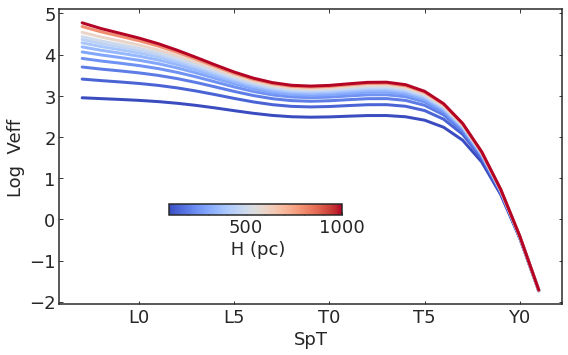

In [145]:
fig, ax=plt.subplots(figsize=(8, 5))
for idx, h in enumerate(wispsim.HS):
    #plt.plot(wispsim.SPGRID, np.log10(OLDERVOLUMES[idx]), color=cmap(cnorm(h/100)),
     #   linewidth=3, linestyle='--', alpha=0.3)
    
    plt.plot(wispsim.SPGRID, np.log10(VOLUMES[idx]), color=cmap(cnorm(h)),
             linewidth=3, label=r'h ={} pc'.format(h), linestyle='-')

#plt.plot(wispsim.SPGRID, np.log10(vsunif), label=r'd$^3$' )
plt.ylabel(r'Log  Veff', fontsize=18)
plt.xlabel('SpT', fontsize=18)
#plt.legend(fontsize=14)
cax = fig.add_axes([.3, 0.4, .3, 0.03])
mp=matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cmap)
cbar=plt.colorbar(mp, cax=cax, orientation='horizontal')
cbar.ax.set_xlabel(r' H (pc)', fontsize=18)
cax.minorticks_on()
plt.minorticks_on()
#plt.grid(which='both')

plt.tight_layout()
ax.set_xticks([20, 25, 30, 35, 40])
ax.set_xticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])

plt.savefig(wisps.OUTPUT_FIGURES+'/simulation_volumes.pdf', bbox_inches='tight')

In [141]:
steps=np.arange(len(pnts))
AREA=4.1*(u.arcmin**2).to(u.radian**2)


In [153]:
np.shape(volumes[:,  ])

(533, 25)

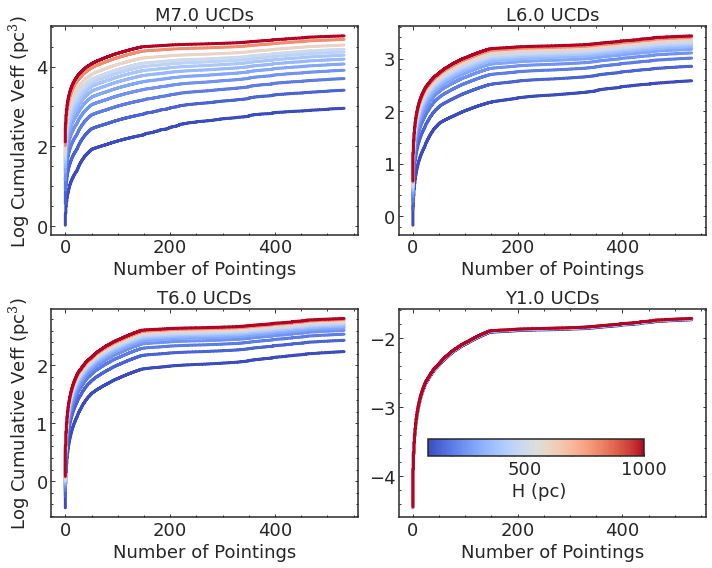

In [155]:
fig, ((ax, ax1), (ax2, ax3))=plt.subplots(figsize=(10, 8), ncols=2, nrows=2)
for idx, h in enumerate(wispsim.HS):
    ax.step(steps, np.log10(np.cumsum(volumes[:, idx, 0])*AREA), color=cmap(cnorm(h)), linewidth=3)
    ax1.step(steps, np.log10(np.cumsum(volumes[:,idx, 9])*AREA), color=cmap(cnorm(h)), linewidth=3)
    ax2.step(steps, np.log10(np.cumsum(volumes[:,idx, -6])*AREA), color=cmap(cnorm(h)), linewidth=3)
    ax3.step(steps, np.log10(np.cumsum(volumes[:, idx, -1])*AREA), color=cmap(cnorm(h)), linewidth=3, label=r'h ={}'.format(h))


ax.set_ylabel(r'Log Cumulative Veff (pc$^3$)', fontsize=18)
ax2.set_ylabel(r'Log Cumulative Veff (pc$^3$)', fontsize=18)

for a in [ax, ax1, ax2, ax3]:
    a.set_xlabel('Number of Pointings', fontsize=18)
    a.minorticks_on()
    
ax.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[0])), fontsize=18)
ax1.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[9])), fontsize=18)
ax2.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[-6])), fontsize=18)
ax3.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[-1])), fontsize=18)

#ax3.legend(fontsize=15)
cax = fig.add_axes([.6, 0.2, .3, 0.03])
mp=matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cmap)
cbar=plt.colorbar(mp, cax=cax, orientation='horizontal')
cbar.ax.set_xlabel(r' H (pc)', fontsize=18)
cax.minorticks_on()

plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/cumulative_volumes.pdf', bbox_inches='tight')